In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

C:\Users\JF\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Importing the data
housing_df = pd.read_csv("train_LR.csv", sep=",")
housing_df = shuffle(housing_df)

In [3]:
#Processing the data
processed_features = housing_df[["GrLivArea"]]

output_targets = housing_df[["SalePrice"]]

In [4]:
#Splitting the data into training, validation, and test sets
training_examples = processed_features[0:1060]
training_targets = output_targets[0:1060]

val_examples = processed_features[1060:1260]
val_targets = output_targets[1060:1260]

test_examples = processed_features[1260:1460]
test_targets = output_targets[1260:1460]

In [5]:
# Configure a numeric feature column for GrLivArea.
my_feature_columns = [tf.feature_column.numeric_column("GrLivArea")]

# Define the preferred optimizer: in this case lets use gradient descent
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
model = tf.estimator.LinearRegressor(feature_columns=my_feature_columns,optimizer=my_optimizer)

In [6]:
#Define the input function required for training
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):

    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
      
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [7]:
#Train the model from the existing data
training = model.train(input_fn = lambda:my_input_fn(training_examples, training_targets),steps=1000)

In [8]:
# Evaluating the model with RMSE
train_predictions = model.predict(input_fn=lambda: my_input_fn(training_examples, training_targets, num_epochs=1, shuffle=False))
val_predictions = model.predict(input_fn=lambda: my_input_fn(val_examples, val_targets, num_epochs=1, shuffle=False))
test_predictions = model.predict(input_fn=lambda: my_input_fn(test_examples, test_targets, num_epochs=1, shuffle=False))

# Format predictions as a NumPy array, so we can calculate error metrics.
train_predictions = np.array([item['predictions'][0] for item in train_predictions])
val_predictions = np.array([item['predictions'][0] for item in val_predictions])
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(train_predictions, training_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
mean_squared_error = metrics.mean_squared_error(val_predictions, val_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on validation data): %0.3f" % root_mean_squared_error)
mean_squared_error = metrics.mean_squared_error(test_predictions, test_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on test data): %0.3f" % root_mean_squared_error)

Root Mean Squared Error (on training data): 58455.327
Root Mean Squared Error (on validation data): 54798.275
Root Mean Squared Error (on test data): 48661.598


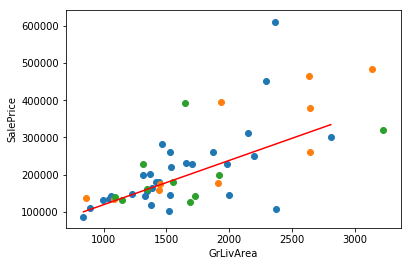

In [9]:
# Evaluating the model with visuals
train_sample = housing_df[0:1060].sample(30)
val_sample = housing_df[1060:1260].sample(10)
test_sample = housing_df[1260:1460].sample(10)

# Get the min and GrLivArea values.
x_0 = train_sample["GrLivArea"].min()
x_1 = train_sample["GrLivArea"].max()

# Retrieve the final weight and bias generated during training.
weight = model.get_variable_value('linear/linear_model/GrLivArea/weights')[0]
bias = model.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted SalePrice for the min and max GrLivArea values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")

# Plot a scatter plot from our data sample.
plt.scatter(train_sample["GrLivArea"], train_sample["SalePrice"])
plt.scatter(val_sample["GrLivArea"], val_sample["SalePrice"])
plt.scatter(test_sample["GrLivArea"], test_sample["SalePrice"])

# Display graph.
plt.show()